In [83]:
from tensorflow.python import keras
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.optimizers import Adam
import numpy as np
import pandas

In [78]:
# Каталог с данными для тестирования
testDir = './dataset/test'
# Размеры изображения
img_width, img_height = 100, 100
input_shape = (img_width, img_height, 3)
# Количество изображений для обучения
nb_train_samples = 656
# Количество изображений для проверки
nb_validation_samples = 83
# Количество изображений для тестирования
nb_test_samples = 83

In [79]:
classes = ['cruassan','polki','ponchik', 'zavitok',]

In [80]:
# https://keras.io/preprocessing/image/
datagen = ImageDataGenerator(rescale=1./255., 
                             rotation_range=45,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             shear_range=0.2,
                             brightness_range=[0.5, 1.0],
                             channel_shift_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode="nearest"
                            )

In [81]:
test_df = pandas.read_csv("./dataset/test.csv")

# https://keras.io/preprocessing/image/#flow_from_dataframe

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=None,
        x_col="filename",
        y_col="label",
        target_size=(img_width, img_height),
        batch_size=1,
        class_mode='categorical')


Found 83 validated image filenames belonging to 4 classes.


In [84]:
# загрузка предварительно обученной модели
with open('modelWork.json') as json_file:
    json_config = json_file.read()
model = keras.models.model_from_json(json_config)
model.load_weights('modelWork.h5')
#добавляем компиляцию, потому что она необходима для корректной работы после загрузки весов
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [85]:
model.summary()
#model.layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
_________________________________________________________________
activation_1 (Activation)    (None, 4)                 0

In [86]:
scores = model.evaluate_generator(test_generator, nb_test_samples)
print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 96.39%


In [15]:
# На каждой эпохе обучения модели происходило сохранение весов. 
# В загружаемом csv-файле представлен список сохраненных весов модели. 
# Каждый вариант проверяем на тестовом наборе.
spisokModels = pandas.read_csv("./SavedModel/modelslist.csv", header = None)
for m in range(len(spisokModels)):
    modelName = spisokModels.iloc[m,0].split('/')
    print(modelName[-1])
    model = keras.models.load_model(spisokModels.iloc[m,0])
    scores = model.evaluate_generator(test_generator, nb_test_samples)
    print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

01-0.9443-0.8929.hdf5
Точность на тестовых данных: 95.18%
02-0.9697-0.9643.hdf5
Точность на тестовых данных: 96.39%
03-0.9697-0.8750.hdf5
Точность на тестовых данных: 95.18%
04-0.9777-0.9107.hdf5
Точность на тестовых данных: 95.18%
05-0.9503-0.9286.hdf5
Точность на тестовых данных: 96.39%


In [87]:
# загружаем созданный csv-файл со списком тестовых картинок и отображаем результаты теста по каждой
confidence = []
spisoktest = pandas.read_csv("./dataset/test.csv")
y = spisoktest.iloc[:,1]
for k in range(len(spisoktest)):
    label = spisoktest.iloc[k,1]
    im = spisoktest.iloc[k,0]
    img = image.load_img(im, target_size=(img_width, img_height))
    # Преобразуем картинку в массив
    x = image.img_to_array(img)
    x = x.reshape(1, x.shape[0],x.shape[1],x.shape[2])
    # Нормализуем изображение
    x /= 255
    prediction = model.predict(x)
    i = np.argmax(prediction)
    confidence.append(prediction[0, :])
    picName = spisoktest.iloc[k,0].split('/')[-1]
    print(k, " | ", picName, " | ", "Название класса распознанного моделью:", classes[i])

0  |  cruassan.234.jpg  |  Название класса распознанного моделью: zavitok
1  |  cruassan.235.jpg  |  Название класса распознанного моделью: cruassan
2  |  cruassan.236.jpg  |  Название класса распознанного моделью: cruassan
3  |  cruassan.237.jpg  |  Название класса распознанного моделью: cruassan
4  |  cruassan.238.jpg  |  Название класса распознанного моделью: zavitok
5  |  cruassan.239.jpg  |  Название класса распознанного моделью: cruassan
6  |  cruassan.240.jpg  |  Название класса распознанного моделью: cruassan
7  |  cruassan.241.jpg  |  Название класса распознанного моделью: cruassan
8  |  cruassan.242.jpg  |  Название класса распознанного моделью: cruassan
9  |  cruassan.243.jpg  |  Название класса распознанного моделью: cruassan
10  |  cruassan.244.jpg  |  Название класса распознанного моделью: cruassan
11  |  cruassan.245.jpg  |  Название класса распознанного моделью: cruassan
12  |  cruassan.246.jpg  |  Название класса распознанного моделью: cruassan
13  |  cruassan.247.jpg 

In [88]:
# Вычисляем значения для построения ROC кривой, чтобы оценить качество обученной модели. 
# Для каждого значения порога определяются значения FAR(false accept rate) и TAR (true accept rate).

FAR = []
TAR = []
for t in range(101):
    t/=100.0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for k in range(len(confidence)):
        for i in range(len(classes)):
            if classes[i] != y.loc[k]:
                if confidence[k][i] >= t:
                    fp += 1
                else:
                    tn += 1
            else:
                if confidence[k][i] >= t:
                    tp += 1
                else:
                    fn += 1
    TAR.append(tp/(tp+fn))
    FAR.append(fp/(tn+fp))  

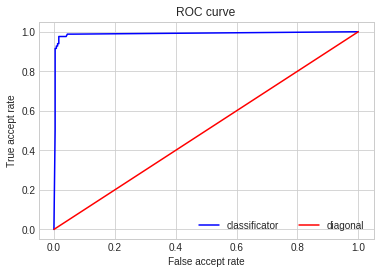

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

# Отображаем на графике ROC кривую - 
# рисуем точки в соответсвии со значениями FAR по оси абсцисс, а TAR – оси ординат.

plt.style.use('seaborn-whitegrid')
plt.plot(FAR, TAR,'-b', label = 'classificator')
plt.plot([0,1], [0,1],'-r', label = 'diagonal')
plt.legend(ncol=2)
plt.xlabel('False accept rate')
plt.ylabel('True accept rate')
plt.title('ROC curve')
plt.show()